In [33]:
# Import necessary dependencies and settings

In [2]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import pandas as pd
import re
import nltk


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

from tensorflow.python.keras import models
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Dropout


## Loading the Data
There are 5 files:
1. Train Texts
2. Train Labels
3. Test Texts
4. Test Labels
5. Dev/Unsupervised

In [3]:
imdb_path = '/Users/jairomelo/Desktop/ML/YORK/ML1010/FinalProject/txtImdb'

# Load the dataset
train_texts = []
train_labels = []
test_texts = []
test_labels = []
for dset in ['train', 'test']:
    for cat in ['pos', 'neg']:
        dset_path = os.path.join(imdb_path, dset, cat)
        for fname in sorted(os.listdir(dset_path)):
            if fname.endswith('.txt'):
                with open(os.path.join(dset_path, fname)) as f:
                    if dset == 'train': train_texts.append(f.read())
                    else: test_texts.append(f.read())
                label = 0 if cat == 'neg' else 1
                if dset == 'train': train_labels.append(label)
                else: test_labels.append(label)

# Converting to np.array
train_texts = np.array(train_texts)
train_labels = np.array(train_labels)
test_texts = np.array(test_texts)
test_labels = np.array(test_labels)



In [4]:
#Development

dev_imdb_path = '/Users/jairomelo/Desktop/ML/YORK/ML1010/FinalProject/txtImdb/train'

dev_texts = []
for fname in sorted(os.listdir(dev_imdb_path)):
    if fname.endswith('.txt'):
        with open(os.path.join(dev_imdb_path, fname)) as f:
            dev_texts.append(f.read())

# Converting to np.array
dev_texts = np.array(dev_texts)


In [5]:
print ('Train samples :', train_texts.shape)
print ('Train labels  :', train_labels.shape)
print ('Test samples  :', test_texts.shape)
print ('Test labels   :', test_labels.shape)
print ('Dev samples   :', dev_texts.shape)


Train samples : (25000,)
Train labels  : (25000,)
Test samples  : (25000,)
Test labels   : (25000,)
Dev samples   : (3,)


In [6]:
size_of_samp = 10
rand_samples_to_check = np.random.randint(len(train_texts), size=size_of_samp)

for samp_num in rand_samples_to_check:
    print ('__________________________________________________')
    print (train_texts[samp_num], '||', train_labels[samp_num])
    print ('__________________________________________________')

__________________________________________________
This is the last time I rent a video without checking in at the IMDB reviews. The Limey is directed by Steven Soderbergh who also wrote wrote the truly awful Nightwatch with Ewan Macgregor and directed such trash as Out of Sight with the anti-talented Jennifer Lopez. Terence Stamp is a fine actor and it is a shame he involved himself in such a bad film. There is frequent confusing editing that seems like it was a last minute decision in order to make up for the lack or story, filming and just plain common sense. This film does everything wrong. What were they thinking? || 0
__________________________________________________
__________________________________________________
i really did not watch this show as often when i was a child but the first episode i remember ever seeing is the episode where Kimmy Gibbler pierced Stephanie ears. when i started high school back in 2000. i had problems all through out high school and i'd rather no

# 3. Data Cleaning and Data Exploration

Remove HTML characters
Remove all punctuation from words.
Remove all words that are known stop words.
Remove all words less than one character
Stemming:
    Reducing inflection in words to their root forms such as mapping a group of words to the same stem even if the stem itself is not a valid word in the Language



In [7]:
#Functions for cleaning HTML tags and punctuation 
import re
def clean_html(sentence):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def clean_punc(word):
    cleaned = re.sub(r'[?|!|\'|#]', r'', word)
    cleaned = re.sub(r'[.|,|)|(|\|/]', r' ', cleaned)
    return cleaned


In [8]:
import string
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
stop = stopwords.words('english')
sno = SnowballStemmer('english')
print (stop)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jairomelo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
final_string = []
s = ''

for sentence in train_texts:
    filtered_sentence = []
    sentence = clean_html(sentence)
    for word in sentence.split():
        for cleaned_word in clean_punc(word).split():
            if (cleaned_word.isalpha() and (len(cleaned_word) > 2) and cleaned_word not in stop):
                s = (sno.stem(cleaned_word.lower())).encode('utf8')
                filtered_sentence.append(s)
            else:
                continue
    strl = b' '.join(filtered_sentence)
    final_string.append(strl.decode('utf8'))

In [ ]:
## Feature Engineering

In [168]:
## Let's plot the average lenght of the reviews

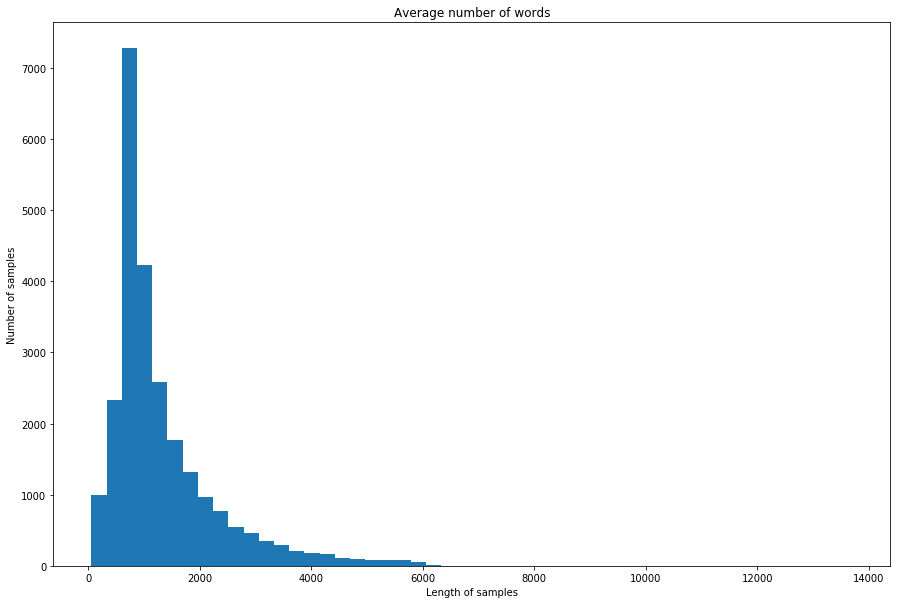

In [10]:
plt.figure(figsize=(15, 10))
plt.hist([len(sample) for sample in list(train_texts)], 50)
plt.xlabel('Length of samples')
plt.ylabel('Number of samples')
plt.title('Average number of words')
plt.show()

Create a frequency distribution of all words

## Vectorizing

Let's now plot a frequency distribution plot of the most seen words in the corpus.

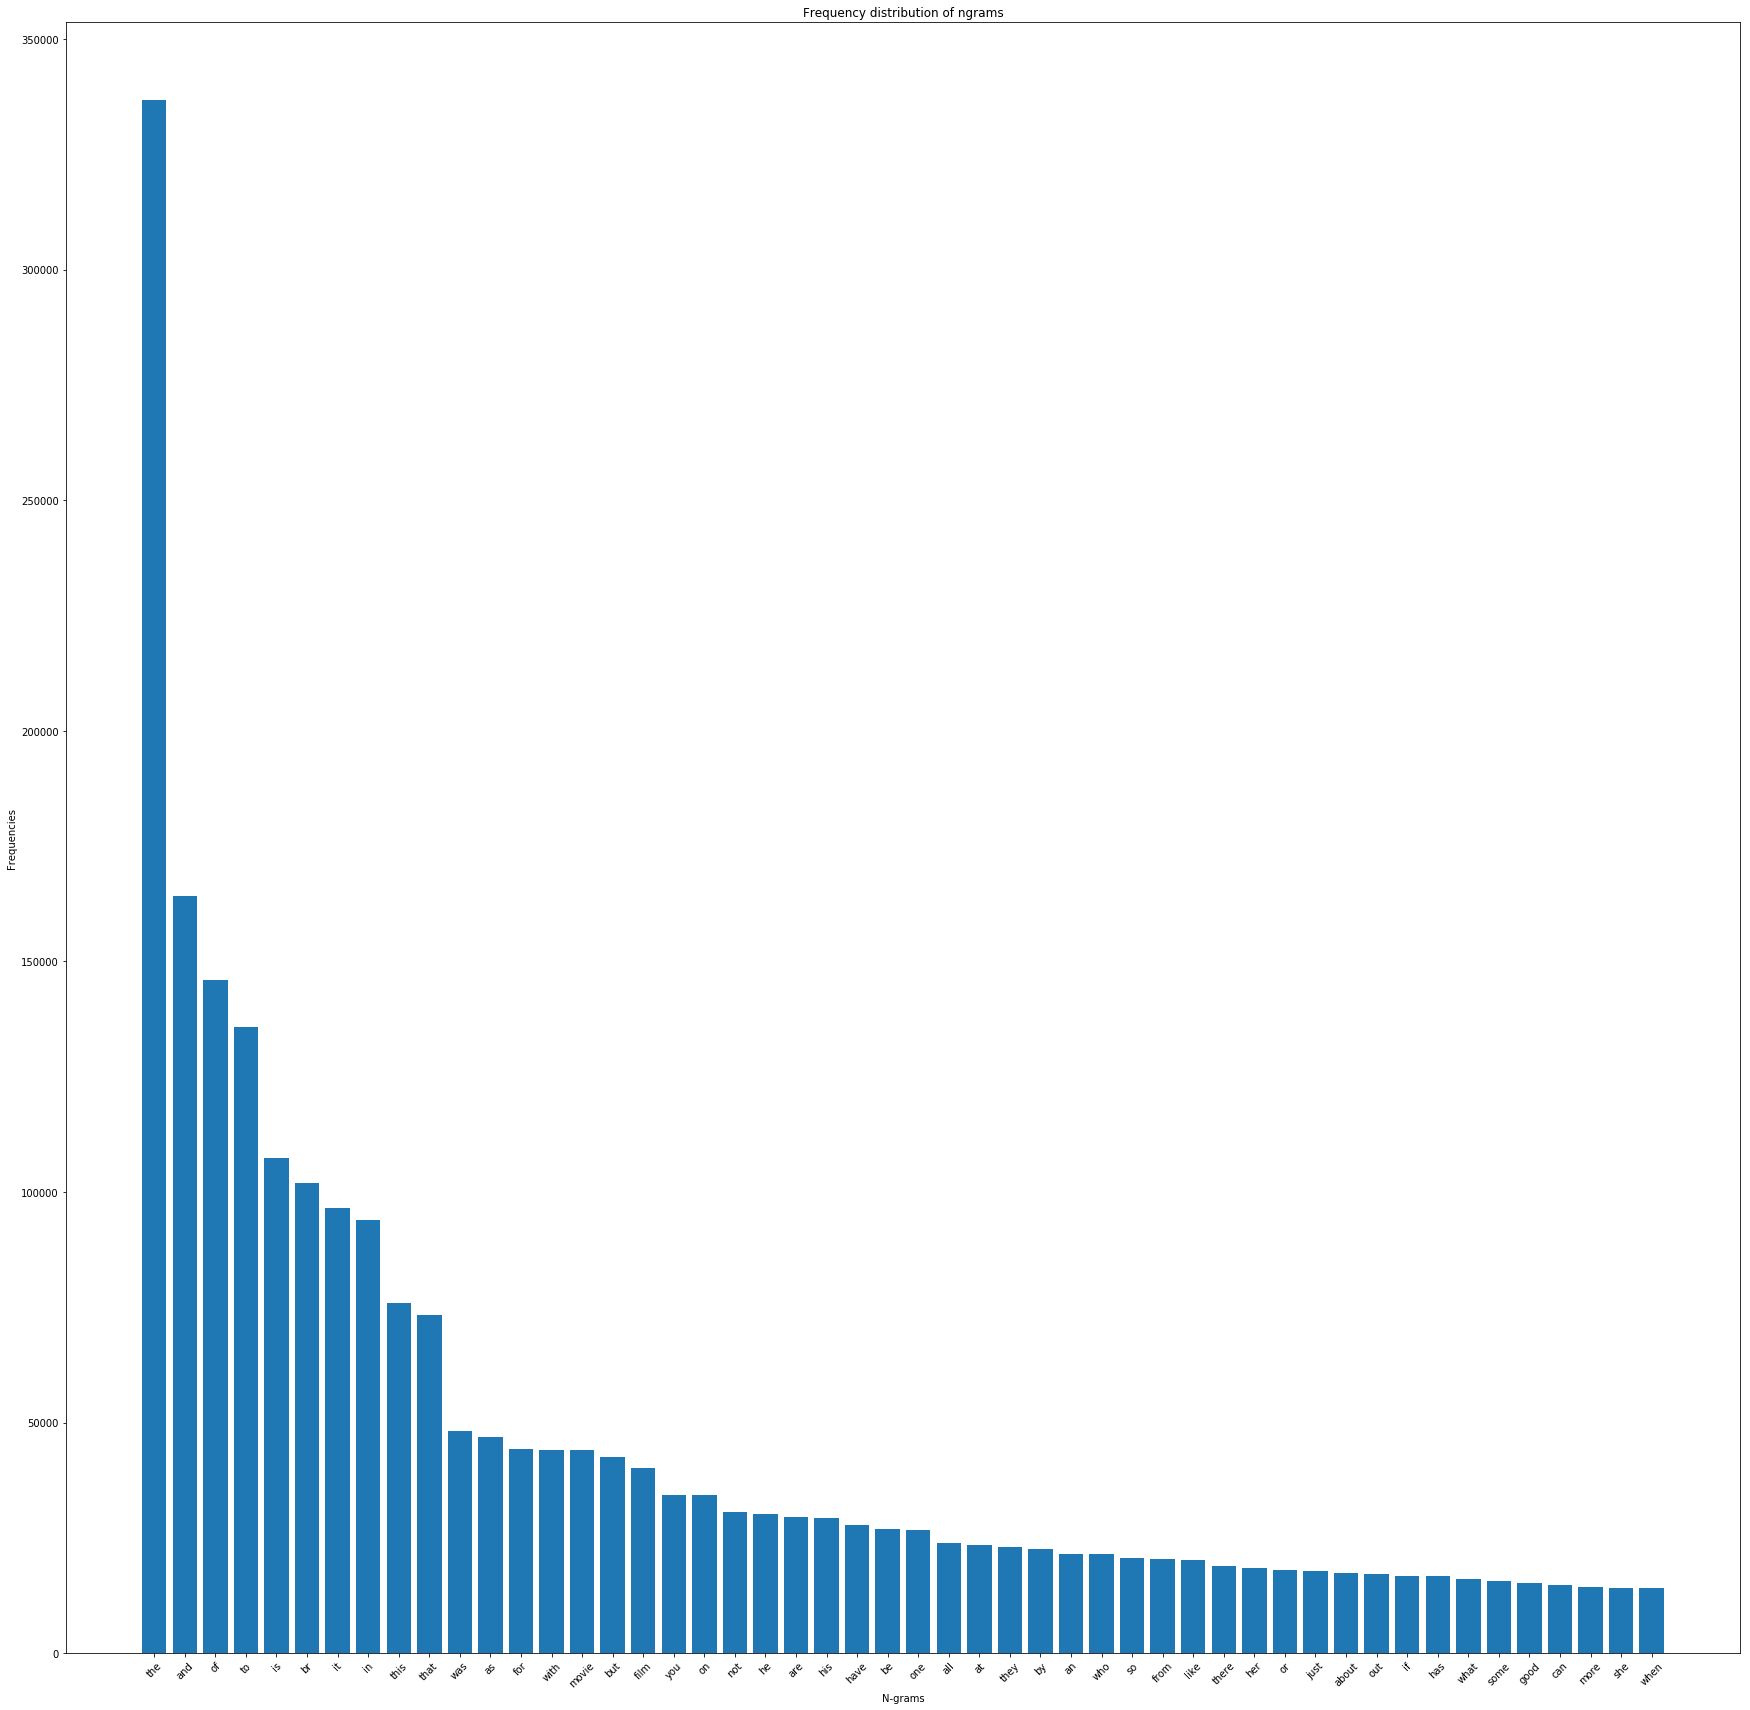

In [11]:

kwargs = {
    'ngram_range' : (1, 1),
    'dtype' : 'int32',
    'strip_accents' : 'unicode',
    'decode_error' : 'replace',
    'analyzer' : 'word'
}

vectorizer = CountVectorizer(**kwargs)
vect_texts = vectorizer.fit_transform(list(train_texts))
all_ngrams = vectorizer.get_feature_names()
num_ngrams = min(50, len(all_ngrams))
all_counts = vect_texts.sum(axis=0).tolist()[0]

all_ngrams, all_counts = zip(*[(n, c) for c, n in sorted(zip(all_counts, all_ngrams), reverse=True)])
ngrams = all_ngrams[:num_ngrams]
counts = all_counts[:num_ngrams]

idx = np.arange(num_ngrams)

plt.figure(figsize=(30, 30))
plt.bar(idx, counts, width=0.8)
plt.xlabel('N-grams')
plt.ylabel('Frequencies')
plt.title('Frequency distribution of ngrams')
plt.xticks(idx, ngrams, rotation=45)
plt.show()

In [ ]:
NGRAM_RANGE = (1, 2)
TOP_K = 20000
TOKEN_MODE = 'word'
MIN_DOC_FREQ = 2

kwargs = {
    'ngram_range' : NGRAM_RANGE,
    'dtype' : 'int32',
    'strip_accents' : 'unicode',
    'decode_error' : 'replace',
    'analyzer' : TOKEN_MODE,
    'min_df' : MIN_DOC_FREQ,
}
    
# Learn Vocab from train texts and vectorize train and val sets
tfidf_vectorizer = TfidfVectorizer(**kwargs)
x_train = tfidf_vectorizer.fit_transform(train_texts)
x_val = tfidf_vectorizer.transform(test_texts)

# Select best k features, with feature importance measured by f_classif
selector = SelectKBest(f_classif, k=min(TOP_K, x_train.shape[1]))
selector.fit(x_train, train_labels)
x_train = selector.transform(x_train).astype('float32')
x_val = selector.transform(x_val).astype('float32')

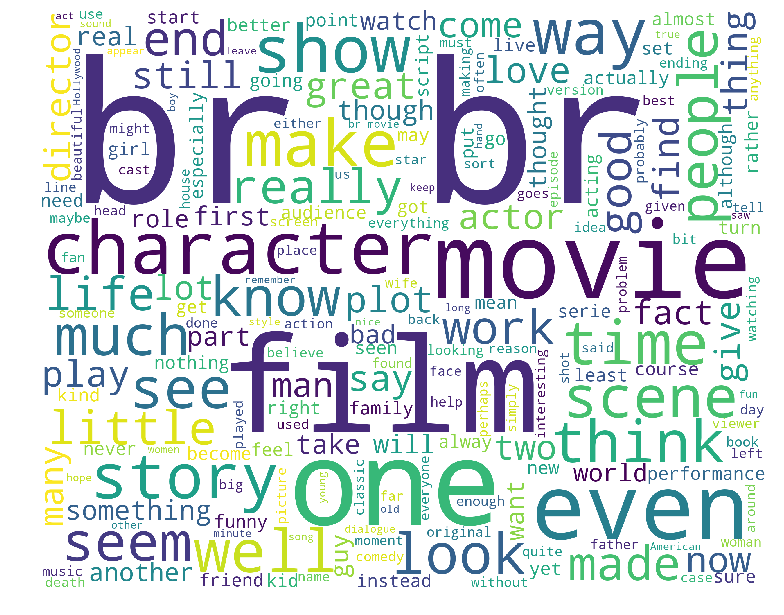

In [12]:
from wordcloud import WordCloud,STOPWORDS

def wordcloud_draw(data, color = 'black'):
    words = ' '.join(data)
    cleaned_word = " ".join([word for word in words.split()
                            if not word.startswith(',')
                            ])
    wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color=color,
                      width=2500,
                      height=2000
                     ).generate(cleaned_word)
    plt.figure(1,figsize=(13, 13))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()
    
wordcloud_draw(train_texts,'white')


# Data Preparation


In [13]:
#Creating clean data file for training

ab = np.zeros(len(final_string), dtype=[('text', 'U10000'), ('label', int)])
ab['text'] = final_string
ab['label'] = train_labels

np.savetxt('train.txt', ab, fmt="%s %i")

#creating a test file

ab = np.zeros(len(test_texts), dtype=[('text', 'U10000'), ('label', int)])
ab['text'] = test_texts
ab['label'] = test_labels

np.savetxt('test.txt', ab, fmt="%s %i")


## Creating a Corpus

In [14]:
#Loading the clean data and corpus

from flair.data import TaggedCorpus
from flair.data_fetcher import NLPTaskDataFetcher, NLPTask

# define columns
columns = {0: 'text', 1: 'pos', 2: 'ner'}

# this is the folder in which train, test and dev files reside
data_folder = '/Users/jairomelo/Desktop/ML/YORK/ML1010/FinalProject'
# retrieve corpus using column format, data folder and the names of the train, dev and test files
corpus: TaggedCorpus = NLPTaskDataFetcher.load_column_corpus(data_folder, columns,
                                                              train_file='train.txt',
                                                              test_file='test.txt',
                                                              dev_file='dev.txt')

Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.
2019-04-10 13:44:47,044 Reading data from /Users/jairomelo/Desktop/ML/YORK/ML1010/FinalProject
2019-04-10 13:44:47,045 Train: /Users/jairomelo/Desktop/ML/YORK/ML1010/FinalProject/train.txt
2019-04-10 13:44:47,045 Dev: /Users/jairomelo/Desktop/ML/YORK/ML1010/FinalProject/dev.txt
2019-04-10 13:44:47,046 Test: /Users/jairomelo/Desktop/ML/YORK/ML1010/FinalProject/test.txt


In [ ]:
## Flair Embeddings

In [15]:
from flair.embeddings import TokenEmbeddings, WordEmbeddings, StackedEmbeddings
from typing import List

# 2. what tag do we want to predict?
tag_type = 'ner'

# 3. make the tag dictionary from the corpus
tag_dictionary = corpus.make_tag_dictionary(tag_type=tag_type)

# 4. initialize embeddings
embedding_types: List[TokenEmbeddings] = [
    WordEmbeddings('glove')
]

embeddings: StackedEmbeddings = StackedEmbeddings(embeddings=embedding_types)



## Training the Model

In [ ]:

# 5. initialize sequence tagger
from flair.models import SequenceTagger

tagger: SequenceTagger = SequenceTagger(hidden_size=256,
                                        embeddings=embeddings,
                                        tag_dictionary=tag_dictionary,
                                        tag_type=tag_type,
                                        use_crf=True)

# 6. initialize trainer
from flair.trainers import ModelTrainer
from flair.training_utils import EvaluationMetric

trainer: ModelTrainer = ModelTrainer(tagger, corpus)

# 7. start training
trainer.train('resources/taggers/example-ner',
              EvaluationMetric.MICRO_F1_SCORE,
              learning_rate=0.1,
              mini_batch_size=32,
              max_epochs=150,
              checkpoint=True)

# 8. stop training at any point

# 9. continue trainer at later point
from pathlib import Path

trainer = ModelTrainer.load_from_checkpoint(Path('resources/taggers/example-ner/checkpoint.pt'), 'SequenceTagger', corpus)
trainer.train('resources/taggers/example-ner',
              EvaluationMetric.MICRO_F1_SCORE,
              learning_rate=0.1,
              mini_batch_size=32,
              max_epochs=150,
              checkpoint=True)

2019-04-10 13:45:37,800 ----------------------------------------------------------------------------------------------------
2019-04-10 13:45:37,801 Evaluation method: MICRO_F1_SCORE
2019-04-10 13:45:37,802 ----------------------------------------------------------------------------------------------------


## Finding the best Learning Rate

In [ ]:

# 10. find learning rate
learning_rate_tsv = ModelTrainer.find_learning_rate('resources/taggers/example-ner',
                                                    'learning_rate.tsv')

# 11. plot the learning rate finder curve
plotter = Plotter()
plotter.plot_learning_rate(learning_rate_tsv)

## Training the Language Model
Now we will use our own Corpus to train our model.

In [ ]:
from pathlib import Path

from flair.data import Dictionary
from flair.models import LanguageModel
from flair.trainers.language_model_trainer import LanguageModelTrainer, TextCorpus

# are you training a forward or backward LM?
is_forward_lm = True

# load the default character dictionary
dictionary: Dictionary = Dictionary.load('chars')

# get your corpus, process forward and at the character level
corpus = TextCorpus(Path('/path/to/your/corpus'),
                    dictionary,
                    is_forward_lm,
                    character_level=True)

# instantiate your language model, set hidden size and number of layers
language_model = LanguageModel(dictionary,
                               is_forward_lm,
                               hidden_size=128,
                               nlayers=1)

# train your language model
trainer = LanguageModelTrainer(language_model, corpus)

trainer.train('resources/taggers/language_model',
              sequence_length=10,
              mini_batch_size=10,
              max_epochs=10)